In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import rioxarray as riox
import glob
from rasterio.crs import CRS
from rasterio.warp import Resampling
from scipy.stats import pearsonr, theilslopes
import geopandas as gpd
import ee
import wxee
wxee.Initialize()

In [2]:
ess_f = '/mnt/d/gen_data/vectors/US_ecoregions/S_USA.EcomapSubsections.shp'

In [3]:
inDIR = '/mnt/c/Users/TBGPEA-Sean/Documents/pheno_trends_ceres/newdata/phenophases/'

In [4]:
f_list = glob.glob(inDIR + 'AVHRR_phenophases_*.nc.tif')

In [5]:
xr_pheno_tmp = riox.open_rasterio(f_list[0])
gdf_ess = gpd.read_file(ess_f)

In [6]:
nlcd2016 = ee.ImageCollection('USGS/NLCD_RELEASES/2016_REL').filter(ee.Filter.eq('system:index', '2016')).first().select('landcover')

In [7]:
bounds = xr_pheno_tmp.rio.bounds()
bounds

(-111.999998481776, 48.99999847518368, -96.99999388882947, 30.99999771011905)

In [8]:
# Load an AVHRR NDVI image.
ee_bounds = ee.Geometry.BBox(bounds[0], bounds[3], bounds[2], bounds[1])
avhrr = ee.ImageCollection('NOAA/CDR/AVHRR/NDVI/V5').first().clip(ee_bounds);
# Get information about the AVHRR projection.
avhrrProjection = avhrr.projection();

# Get rangeland > 70% at the AVHRR scale from the landcover band
range_mask = nlcd2016.select('landcover').eq(71).toFloat().reduceResolution(reducer=ee.Reducer.mean(), 
                                                                           maxPixels=1024,
                                                                           bestEffort=True).reproject(crs=avhrrProjection).gt(0.70).clip(ee_bounds).set({'system:time_start': nlcd2016.get('system:time_start')})

In [9]:
xr_range_mask = range_mask.wx.to_xarray(scale=5600).squeeze()['landcover']

Downloading:   0%|          | 0.00/8.75k [00:00<?, ?iB/s]

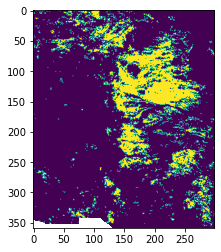

<AxesSubplot:>

In [10]:
from rasterio.plot import show
show(xr_range_mask.data)

In [11]:
#xr_range_mask_ri = xr_range_mask.reindex_like(xr_pheno_tmp, method='nearest')

In [12]:
def corr_pearson(x1, x2):
    x1 = x1[~np.isnan(x2)]
    x2 = x2[~np.isnan(x2)]
    if len(x1) > 2:
        return pearsonr(x1, x2) # to return the correlation coefficient and p-value
    else:
        return(np.nan, np.nan)

def corr_theilsen(y, x):
    y = y[~np.isnan(x)]
    x = x[~np.isnan(x)]
    if len(x) > 2:
        slope, intercept, lo_slope, hi_slope = theilslopes(y, x)
        if np.sign(lo_slope) == np.sign(hi_slope):
            sig = 1
        else:
            sig = 0
        return (slope, sig)
    else:
        return(np.nan, np.nan)
    
def corr_xr(ds, var, coord='year', func=corr_pearson):
    """Finds the correlation along a given dimension of a dataarray."""
    da = ds[var]
    ds_out = xr.apply_ufunc(func, 
                          da[coord], 
                          da,
                          input_core_dims=[[coord],[coord]] , 
                          output_core_dims=[[], []],
                          vectorize=True,
                          dask='parallelized',
                          output_dtypes=[float, float]
                          )
    ds_out[0].name = 'r_' + var
    ds_out[1].name = 'sig_' + var
    return ds_out

from rasterio import features
def shp2mask(shp, xr_object, transform, outshape, fill=0, dtype='int16', **kwargs):
    raster = features.rasterize(shp, fill=fill, transform=transform,
                                out_shape=outshape, dtype=dtype, **kwargs)
    return xr.DataArray(raster,
                        coords=(xr_object.coords['y'].values, xr_object.coords['x']),
                        dims=('y', 'x'))

In [13]:
ds_list = []
for f in f_list:
    da_tmp = riox.open_rasterio(f)
    name_dict = {}
    for idx, var in enumerate(da_tmp.attrs['long_name']):
        name_dict[idx+1] = var
    ds_tmp = da_tmp.to_dataset('band').rename(name_dict)
    del(ds_tmp.attrs['long_name'])
    yr_tmp = ds_tmp['YEAR'].values.flatten()[0]
    ds_tmp = ds_tmp.drop_vars('YEAR')
    ds_tmp = ds_tmp.assign_coords({'YEAR': int(yr_tmp)})
    ds_list.append(ds_tmp)

In [14]:
ds = xr.concat(ds_list, 'YEAR')

In [15]:
ds = ds.where(ds['YEAR'] > 1981, drop=True)

In [16]:
#ds = ds.where(xr_range_mask_ri == 1.0)

In [17]:
ess_info = gdf_ess[['SUBSECTION', 'geometry']].reset_index(drop=True).reset_index().rename(columns={'index': 'id'})
ess_dict = {row.id+1: row.SUBSECTION for _, row in ess_info.iterrows()}
ess_dict[0] = 0
ess_mask_shp = [(row.geometry, row.id+1) for _, row in ess_info.iterrows()]
ess_mask = shp2mask(shp=ess_mask_shp, 
                     transform=xr_pheno_tmp.rio.transform(), 
                     outshape=xr_pheno_tmp.shape[1:], 
                     xr_object=xr_pheno_tmp)
ess_mask = np.array([ess_dict[i] for i in ess_mask.values.flatten()]).reshape(ess_mask.shape)

In [18]:
ess_info

,id,SUBSECTION,geometry
0,0,238,"POLYGON ((-111.23019 44.63155, -111.23205 44.6..."
1,1,239,"POLYGON ((-87.38362 46.52214, -87.38799 46.518..."
2,2,240,"POLYGON ((-114.90571 43.06139, -114.90363 43.0..."
3,3,241,"POLYGON ((-122.59502 39.08838, -122.59992 39.0..."
4,4,242,"POLYGON ((-115.31336 43.69705, -115.31859 43.6..."
...,...,...,...
1228,1228,1155,"MULTIPOLYGON (((-79.33813 33.79108, -79.34629 ..."
1229,1229,1156,"POLYGON ((-90.04441 32.23091, -90.05088 32.222..."
1230,1230,1157,"POLYGON ((-100.47519 31.35891, -100.50397 31.3..."
1231,1231,1158,"POLYGON ((-100.50899 32.35149, -100.50980 32.3..."


In [19]:
ds = ds.assign(ess=(['y', 'x'], ess_mask))
ds = ds.set_coords('ess')

In [20]:
ds.rio.transform()

Affine(0.0500000153098218, 0.0, -111.999998481776,
       0.0, 0.050000002125179535, 30.99999771011905)

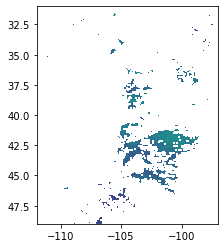

<AxesSubplot:>

In [21]:
show(ds['SOS'].mean(dim='YEAR').data, transform=ds.rio.transform())

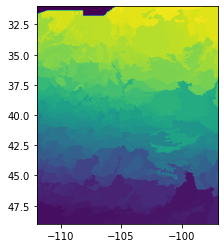

<AxesSubplot:>

In [22]:
show(ds['ess'], transform=ds.rio.transform())
#ds

<AxesSubplot:>

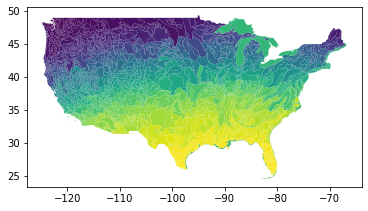

In [23]:
gdf_ess.plot('SUBSECTION')

In [24]:
ngl_f = '/mnt/d/gen_data/vectors/US_natl_grasslands/S_USA.NationalGrassland.shp'
gdf_ngl = gpd.read_file(ngl_f)
gdf_ngl.columns

Index(['NATIONALGR', 'GRASSLANDN', 'GIS_ACRES', 'SHAPE_AREA', 'SHAPE_LEN',
       'geometry'],
      dtype='object')

In [25]:
ngl_info = gdf_ngl[['GRASSLANDN', 'geometry']].reset_index(drop=True).reset_index().rename(columns={'index': 'id'})
ngl_dict = {row.id+1: row.GRASSLANDN for _, row in ngl_info.iterrows()}
ngl_dict[0] = 0
ngl_mask_shp = [(row.geometry, row.id+1) for _, row in ngl_info.iterrows()]
ngl_mask = shp2mask(shp=ngl_mask_shp, 
                     transform=xr_pheno_tmp.rio.transform(), 
                     outshape=xr_pheno_tmp.shape[1:], 
                     xr_object=xr_pheno_tmp)
ngl_mask = np.array([ngl_dict[i] for i in ngl_mask.values.flatten()]).reshape(ngl_mask.shape)

In [26]:
ds = ds.assign(ngl=(['y', 'x'], ngl_mask))
ds = ds.set_coords('ngl')

In [27]:
np.unique(ds['ngl'].values)

array(['0', 'Black Kettle National Grassland',
       'Buffalo Gap National Grassland', 'Cedar River National Grassland',
       'Cimarron National Grassland', 'Comanche National Grassland',
       'Fort Pierre National Grassland', 'Grand River National Grassland',
       'Kiowa National Grassland', 'Little Missouri National Grassland',
       'Lyndon B. Johnson National Grassland',
       'Oglala National Grassland', 'Pawnee National Grassland',
       'Rita Blanca National Grassland', 'Sheyenne National Grassland',
       'Thunder Basin National Grassland'], dtype='<U36')

In [28]:
#y_test = slice(40.844960, 40.95)
#x_test = slice(-104.5, -104.30)
ng_dict = {
    'Oglala National Grassland': 'ong',
    'Little Missouri National Grassland': 'lmng',
    'Buffalo Gap National Grassland': 'bgng',
    'Pawnee National Grassland': 'pawnee',
    'Thunder Basin National Grassland': 'tbng'
}

#ngl_name = 'Oglala National Grassland'
#ngl_short = 'ong'
for ngl_name in ng_dict:
    ngl_short = ng_dict[ngl_name]
    ds_ngl = ds.where(ds['ngl'] == ngl_name)
    df_ngl = ds_ngl.where(ds_ngl.notnull, drop=True).to_dataframe().reset_index()
    import matplotlib.pyplot as plt
    import seaborn as sns
    #ax1 = sns.pointplot(x='YEAR', y='LGU', data=df_ngl[df_ngl['num_pks'] == 1.0], join=False, )
    fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(14, 10))
    for idx, yvar in enumerate(['LGU', 'LGS', 'LGD', 'LOS']):
        sns.regplot(x='YEAR', y=yvar, data=df_ngl[df_ngl['num_pks'] > 0], scatter=False, ax=axs.flatten()[idx])
        xd = df_ngl[df_ngl['num_pks'] > 0]['YEAR'].unique()
        yd = df_ngl[df_ngl['num_pks'] > 0].groupby('YEAR').mean()[yvar]
        yerrd = df_ngl[df_ngl['num_pks'] > 0].groupby('YEAR').sem()[yvar]
        axs.flatten()[idx].errorbar(xd, yd, yerr=yerrd, fmt='o', capsize=5, zorder=1, color='C0')
    plt.savefig('/mnt/c/Users/TBGPEA-Sean/Documents/pheno_trends_ceres/' + ngl_short + '_lengths.png', dpi=150)
    plt.close()

    fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(14, 10))
    for idx, yvar in enumerate(['SOS', 'MGU', 'MAT', 'POS', 'SEN', 'MGD', 'EOS']):
        sns.regplot(x='YEAR', y=yvar, data=df_ngl[df_ngl['num_pks'] > 0], scatter=False, ax=axs.flatten()[idx])
        xd = df_ngl[df_ngl['num_pks'] > 0]['YEAR'].unique()
        yd = df_ngl[df_ngl['num_pks'] > 0].groupby('YEAR').mean()[yvar]
        yerrd = df_ngl[df_ngl['num_pks'] > 0].groupby('YEAR').sem()[yvar]
        axs.flatten()[idx].errorbar(xd, yd, yerr=yerrd, fmt='o', capsize=5, zorder=1, color='C0')
    plt.savefig('/mnt/c/Users/TBGPEA-Sean/Documents/pheno_trends_ceres/' + ngl_short + '_doys.png', dpi=150)
    plt.close()
#plt.scatter(ds_ngl['YEAR'], ds_ngl['LGS'])
#plt.scatter(ds_ngl.where(ds_ngl['num_pks'] > 1.5)['YEAR'], 
#            ds_ngl.where(ds_ngl['num_pks'] > 1.5)['LGS'], c='orange')
#plt.ylim((0, 350))

In [29]:
corr_list = []
sig_list = []
corr_func = corr_pearson
for v in list(ds.keys())[1:-1]:
    print(v)
    da_tup = corr_xr(ds.where(ds['num_pks']> 0), v, 'YEAR', corr_func)
    corr_list.append(da_tup[0])
    if corr_func == corr_pearson:
        sig_tmp = da_tup[1] < 0.05
    sig_tmp = da_tup[1]
    corr_sig_tmp = da_tup[0] * sig_tmp
    corr_sig_tmp.name = v
    sig_list.append(corr_sig_tmp)

ndvi_max
ndvi_gs_mean
SOS
MGU
MAT
POS
POS2
SEN
MGD
EOS
LGU
LGS
LGD
LOS


In [30]:
from rasterio.crs import CRS
ds_corr = xr.merge(corr_list)
#ds_corr.rio.write_crs(CRS.from_string('EPSG:4326'), inplace=True)
ds_sig = xr.merge(sig_list)
ds_sig = ds_sig.where(ds_sig != 0)
#ds_sig.rio.write_crs(CRS.from_string('EPSG:4326'), inplace=True)

In [31]:
df_ess_corr = ds_corr.groupby('ess').mean().to_dataframe().reset_index()

In [32]:
ess_mask05 = ds_corr['r_SOS'].notnull().groupby('ess').sum() / (ds_corr['r_SOS'].isnull().groupby('ess').sum() +
                                                   ds_corr['r_SOS'].notnull().groupby('ess').sum()) > 0.05

In [33]:
df_ess_corr['mask5pct'] = ess_mask05

In [34]:
gdf_ess_sub = gdf_ess[gdf_ess['SUBSECTION'].isin(df_ess_corr['ess'])]

In [35]:
gdf_ess_out = gdf_ess_sub.set_index('SUBSECTION').join(df_ess_corr.set_index('ess'), )

In [36]:
import os
#gdf_ess_out.reset_index().to_file(os.path.join(inDIR, 'ESS_pheno_corr.shp'))

In [37]:
ds_sig.isel(x=slice(120, 140), y=slice(100, 120))

<xarray.Dataset>
Dimensions:       (y: 20, x: 20)
Coordinates:
    spatial_ref   int64 0
  * x             (x) float64 -106.0 -105.9 -105.9 ... -105.1 -105.1 -105.0
  * y             (y) float64 36.02 36.07 36.12 36.17 ... 36.87 36.92 36.97
    ess           (y, x) int64 959 959 959 959 945 945 ... 832 832 945 945 945
    ngl           (y, x) <U36 '0' '0' '0' '0' '0' '0' ... '0' '0' '0' '0' '0'
Data variables: (12/14)
    ndvi_max      (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    ndvi_gs_mean  (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    SOS           (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    MGU           (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    MAT           (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    POS           (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    ...            ...
    MGD           (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    EOS           (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    LGU           (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    LGS           (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    LGD           (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    LOS           (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan

# Climate correlations

In [38]:
import os
#ds_corr.rio.to_raster(os.path.join(inDIR, 'phenophase_corrs.tif'))
#ds_sig.rio.to_raster(os.path.join(inDIR, 'phenophase_corrs_sig.tif'))

In [39]:
ds_clim = riox.open_rasterio('/mnt/c/Users/TBGPEA-Sean/Documents/pheno_trends_ceres/newdata/climate/jja1981-2018_corr_3-22-22.grd')

In [40]:
ds_clim = ds_clim.rio.set_crs(4326).squeeze()
ds_clim.name = 'precip_jja'
ds_clim = ds_clim.to_dataset()

In [41]:
ds_clim = ds_clim.rio.clip_box(*xr_range_mask.rio.bounds())
xr_range_mask_ri = xr_range_mask.reindex_like(ds_clim, method='nearest')
#xr_range_mask_ri
ds_clim = ds_clim.where(xr_range_mask_ri == 1)

In [42]:
ess_info = gdf_ess[['SUBSECTION', 'geometry']].reset_index(drop=True).reset_index().rename(columns={'index': 'id'})
ess_dict = {row.id+1: row.SUBSECTION for _, row in ess_info.iterrows()}
ess_dict[0] = 0
ess_mask_shp = [(row.geometry, row.id+1) for _, row in ess_info.iterrows()]
ess_mask = shp2mask(shp=ess_mask_shp, 
                     transform=ds_clim.rio.transform(), 
                     outshape=ds_clim['precip_jja'].shape, 
                     xr_object=ds_clim['precip_jja'])
ess_mask = np.array([ess_dict[i] for i in ess_mask.values.flatten()]).reshape(ess_mask.shape)
ds_clim = ds_clim.assign(ess=(['y', 'x'], ess_mask))
ds_clim = ds_clim.set_coords('ess')
ds_clim

<xarray.Dataset>
Dimensions:      (y: 434, x: 362)
Coordinates:
    band         int64 1
  * x            (x) float64 -112.0 -112.0 -112.0 -111.9 ... -97.08 -97.04 -97.0
  * y            (y) float64 49.04 49.0 48.96 48.92 ... 31.12 31.08 31.04 31.0
    spatial_ref  int64 0
    time         datetime64[ns] 2016-01-01
    ess          (y, x) int64 0 0 0 0 0 0 0 ... 1135 1135 1135 1135 1135 1135
Data variables:
    precip_jja   (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan

In [43]:
df_ess_clim = ds_clim.groupby('ess').mean().to_dataframe().reset_index()

In [44]:
df_ess_clim

,ess,precip_jja,band,spatial_ref,time
0,0,0.129343,1,0,2016-01-01
1,44,-0.198731,1,0,2016-01-01
2,46,0.000847,1,0,2016-01-01
3,49,-0.071684,1,0,2016-01-01
4,53,0.271067,1,0,2016-01-01
...,...,...,...,...,...
374,1162,NaN,1,0,2016-01-01
375,1171,0.161311,1,0,2016-01-01
376,1178,NaN,1,0,2016-01-01
377,1188,NaN,1,0,2016-01-01


In [45]:
ess_mask05 = ds_clim['precip_jja'].notnull().groupby('ess').sum() / (ds_clim['precip_jja'].isnull().groupby('ess').sum() +
                                                   ds_clim['precip_jja'].notnull().groupby('ess').sum()) > 0.05

In [46]:
df_ess_clim['mask5pct'] = ess_mask05

In [47]:
gdf_ess_sub = gdf_ess[gdf_ess['SUBSECTION'].isin(df_ess_clim['ess'])]

In [48]:
gdf_ess_out = gdf_ess_sub.set_index('SUBSECTION').join(df_ess_clim.set_index('ess'), )

In [49]:
import os
gdf_ess_out.drop(columns='time').reset_index().to_file(os.path.join(inDIR, 'ESS_clim_corr.shp'))

/tmp/ipykernel_228/3065781260.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_ess_out.drop(columns='time').reset_index().to_file(os.path.join(inDIR, 'ESS_clim_corr.shp'))


In [50]:
ngl_info = gdf_ngl[['GRASSLANDN', 'geometry']].reset_index(drop=True).reset_index().rename(columns={'index': 'id'})
ngl_dict = {row.id+1: row.GRASSLANDN for _, row in ngl_info.iterrows()}
ngl_dict[0] = 0
ngl_mask_shp = [(row.geometry, row.id+1) for _, row in ngl_info.iterrows()]
ngl_mask = shp2mask(shp=ngl_mask_shp, 
                     transform=ds_clim.rio.transform(), 
                     outshape=ds_clim['precip_jja'].shape, 
                     xr_object=ds_clim['precip_jja'])
ngl_mask = np.array([ngl_dict[i] for i in ngl_mask.values.flatten()]).reshape(ngl_mask.shape)

In [51]:
ds_clim = ds_clim.assign(ngl=(['y', 'x'], ngl_mask))
ds_clim = ds_clim.set_coords('ngl')

In [52]:
df_ngl_corr = ds_clim.groupby('ngl').mean().to_dataframe().reset_index().drop(columns=['band', 'spatial_ref', 'time'])

In [53]:
df_ngl_corr = pd.merge(df_ngl_corr, 
                       ds_corr.groupby('ngl').mean().to_dataframe().reset_index().drop(columns=['spatial_ref']),
                       on='ngl')

In [54]:
df_ngl_corr

,ngl,precip_jja,r_ndvi_max,r_ndvi_gs_mean,r_SOS,r_MGU,r_MAT,r_POS,r_POS2,r_SEN,r_MGD,r_EOS,r_LGU,r_LGS,r_LGD,r_LOS
0,0,0.190132,0.238658,0.131647,0.081011,0.130815,0.073834,0.056382,-0.026039,0.027466,-0.090261,-0.012183,-0.016026,-0.148035,-0.032736,-0.065098
1,Black Kettle National Grassland,0.012878,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Buffalo Gap National Grassland,0.225873,0.270952,0.138206,0.044648,0.155724,0.112187,0.099223,-0.033619,0.034860,-0.182500,0.044765,0.041083,-0.226047,0.001544,-0.007689
3,Cedar River National Grassland,0.318899,0.170044,-0.074113,-0.217472,0.159126,0.024983,0.103553,0.420221,0.125536,0.097681,0.244799,0.235510,-0.006624,0.101087,0.317352
4,Cimarron National Grassland,0.176626,0.322054,0.130628,0.001011,-0.019878,-0.022968,-0.077561,0.254095,-0.075607,-0.085888,0.035168,-0.022680,-0.032528,0.092291,0.021915
5,Comanche National Grassland,0.248857,0.279011,0.288777,0.058816,0.085994,0.060897,0.048587,0.095390,0.069772,0.005747,-0.079093,0.007948,-0.074399,-0.117739,-0.084514
6,Fort Pierre National Grassland,0.197100,0.233979,0.115992,0.009476,0.136617,0.088543,0.060975,-0.084512,0.020419,-0.128503,0.071391,0.049419,-0.163452,0.041850,0.034850
7,Grand River National Grassland,0.327345,0.044015,-0.095065,-0.140111,0.097888,0.069193,0.055700,0.257337,0.050570,-0.067031,0.182758,0.177679,-0.105642,0.123460,0.219367
8,Kiowa National Grassland,-0.075831,0.315954,0.301145,0.052670,0.062438,0.062136,0.037302,-0.064615,0.025066,0.125038,0.054471,0.005995,0.039339,0.009834,-0.006361
9,Little Missouri National Grassland,0.182803,0.214815,0.092281,0.147310,0.265646,0.322230,0.269191,0.161364,0.116964,-0.092511,-0.027116,0.051718,-0.203287,-0.103363,-0.128725


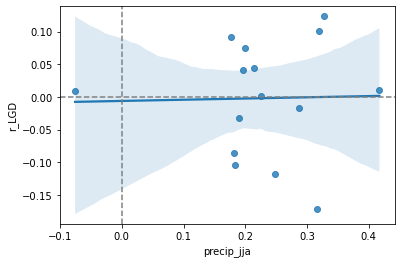

In [55]:
sns.regplot(x='precip_jja', y='r_LGD', data=df_ngl_corr, scatter=True)
plt.axhline(y=0, linestyle='dashed', color='grey')
plt.axvline(x=0, linestyle='dashed', color='grey')

In [56]:
df_ngl_corr

,ngl,precip_jja,r_ndvi_max,r_ndvi_gs_mean,r_SOS,r_MGU,r_MAT,r_POS,r_POS2,r_SEN,r_MGD,r_EOS,r_LGU,r_LGS,r_LGD,r_LOS
0,0,0.190132,0.238658,0.131647,0.081011,0.130815,0.073834,0.056382,-0.026039,0.027466,-0.090261,-0.012183,-0.016026,-0.148035,-0.032736,-0.065098
1,Black Kettle National Grassland,0.012878,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Buffalo Gap National Grassland,0.225873,0.270952,0.138206,0.044648,0.155724,0.112187,0.099223,-0.033619,0.034860,-0.182500,0.044765,0.041083,-0.226047,0.001544,-0.007689
3,Cedar River National Grassland,0.318899,0.170044,-0.074113,-0.217472,0.159126,0.024983,0.103553,0.420221,0.125536,0.097681,0.244799,0.235510,-0.006624,0.101087,0.317352
4,Cimarron National Grassland,0.176626,0.322054,0.130628,0.001011,-0.019878,-0.022968,-0.077561,0.254095,-0.075607,-0.085888,0.035168,-0.022680,-0.032528,0.092291,0.021915
5,Comanche National Grassland,0.248857,0.279011,0.288777,0.058816,0.085994,0.060897,0.048587,0.095390,0.069772,0.005747,-0.079093,0.007948,-0.074399,-0.117739,-0.084514
6,Fort Pierre National Grassland,0.197100,0.233979,0.115992,0.009476,0.136617,0.088543,0.060975,-0.084512,0.020419,-0.128503,0.071391,0.049419,-0.163452,0.041850,0.034850
7,Grand River National Grassland,0.327345,0.044015,-0.095065,-0.140111,0.097888,0.069193,0.055700,0.257337,0.050570,-0.067031,0.182758,0.177679,-0.105642,0.123460,0.219367
8,Kiowa National Grassland,-0.075831,0.315954,0.301145,0.052670,0.062438,0.062136,0.037302,-0.064615,0.025066,0.125038,0.054471,0.005995,0.039339,0.009834,-0.006361
9,Little Missouri National Grassland,0.182803,0.214815,0.092281,0.147310,0.265646,0.322230,0.269191,0.161364,0.116964,-0.092511,-0.027116,0.051718,-0.203287,-0.103363,-0.128725


# Climate annual

In [57]:
ds_clim_ann = riox.open_rasterio('/mnt/c/Users/TBGPEA-Sean/Documents/pheno_trends_ceres/newdata/climate/jja_sum_3-22-22.grd')

In [58]:
ds_clim_ann = ds_clim_ann.rename({'band': 'YEAR'})
ds_clim_ann['YEAR'] = ds_clim_ann['YEAR'] + 1981 - 1
ds_clim_ann = ds_clim_ann.rio.set_crs(4326).squeeze()
ds_clim_ann.name = 'precip_jja'
ds_clim_ann = ds_clim_ann.to_dataset()

In [59]:
ds_clim_ann = ds_clim_ann.rio.clip_box(*xr_range_mask.rio.bounds())
xr_range_mask_ri = xr_range_mask.reindex_like(ds_clim_ann, method='nearest')
#xr_range_mask_ri
ds_clim_ann = ds_clim_ann.where(xr_range_mask_ri == 1)

In [60]:
ngl_info = gdf_ngl[['GRASSLANDN', 'geometry']].reset_index(drop=True).reset_index().rename(columns={'index': 'id'})
ngl_dict = {row.id+1: row.GRASSLANDN for _, row in ngl_info.iterrows()}
ngl_dict[0] = 0
ngl_mask_shp = [(row.geometry, row.id+1) for _, row in ngl_info.iterrows()]
ngl_mask = shp2mask(shp=ngl_mask_shp, 
                     transform=ds_clim_ann.rio.transform(), 
                     outshape=ds_clim_ann.sel(YEAR=1981)['precip_jja'].shape, 
                     xr_object=ds_clim_ann.sel(YEAR=1981)['precip_jja'])
ngl_mask = np.array([ngl_dict[i] for i in ngl_mask.values.flatten()]).reshape(ngl_mask.shape)

In [61]:
ds_clim_ann = ds_clim_ann.assign(ngl=(['y', 'x'], ngl_mask))
ds_clim_ann = ds_clim_ann.set_coords('ngl')

In [62]:
df_ngl_ann = ds_clim_ann.groupby('ngl').mean().to_dataframe().reset_index().drop(columns=['spatial_ref'])

In [63]:
df_ngl_ann = pd.merge(df_ngl_ann, 
                       ds.groupby('ngl').mean().to_dataframe().reset_index().drop(columns=['spatial_ref']),
                       on=['ngl', 'YEAR'])

In [64]:
df_ngl_ann = df_ngl_ann[~df_ngl_ann['ngl'].isin(['0', 'Black Kettle National Grassland'])]

In [65]:
df_ngl_ann.columns

Index(['ngl', 'YEAR', 'precip_jja', 'time', 'ndvi_max_gap', 'ndvi_max',
       'ndvi_gs_mean', 'SOS', 'MGU', 'MAT', 'POS', 'POS2', 'SEN', 'MGD', 'EOS',
       'LGU', 'LGS', 'LGD', 'LOS', 'num_pks'],
      dtype='object')

In [66]:
for ngl in ng_dict:
    print(ngl)
    plt.figure(figsize=(14, 14))
    corrMatrix = df_ngl_ann[df_ngl_ann['ngl'] == ngl].corr()
    ngl_short = ng_dict[ngl]
    sns.heatmap(corrMatrix, annot=True, cmap='Spectral_r')
    plt.savefig('/mnt/c/Users/TBGPEA-Sean/Documents/pheno_trends_ceres/' + ngl_short + '_clim_ann_corr.png', 
                dpi=150)
    plt.close()

Oglala National Grassland
Little Missouri National Grassland
Buffalo Gap National Grassland
Pawnee National Grassland
Thunder Basin National Grassland


In [67]:
y_var = 'POS'

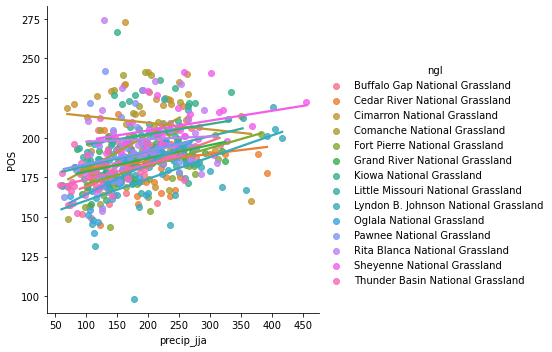

In [68]:
sns.lmplot(x='precip_jja', y=y_var, hue='ngl', data=df_ngl_ann,  ci=None)

In [200]:
for c in df_ngl_ann.columns[4:]:
    sns.lmplot(x='precip_jja', y=c, col='ngl', col_wrap=4, data=df_ngl_ann,  ci=None)
    plt.savefig('/mnt/c/Users/TBGPEA-Sean/Documents/pheno_trends_ceres/' + 'ngls_precip_jja_vs_' + c+ '.png', 
                dpi=150)
    plt.close()

In [71]:
ess_info = gdf_ess[['SUBSECTION', 'geometry']].reset_index(drop=True).reset_index().rename(columns={'index': 'id'})
ess_dict = {row.id+1: row.SUBSECTION for _, row in ess_info.iterrows()}
ess_dict[0] = 0
ess_mask_shp = [(row.geometry, row.id+1) for _, row in ess_info.iterrows()]
ess_mask = shp2mask(shp=ess_mask_shp, 
                     transform=ds_clim_ann.rio.transform(), 
                     outshape=ds_clim_ann.sel(year=1981)['precip_jja'].shape, 
                     xr_object=ds_clim_ann.sel(year=1981)['precip_jja'])
ess_mask = np.array([ess_dict[i] for i in ess_mask.values.flatten()]).reshape(ess_mask.shape)
ds_clim_ann = ds_clim_ann.assign(ess=(['y', 'x'], ess_mask))
ds_clim_ann = ds_clim_ann.set_coords('ess')
ds_clim_ann

<xarray.Dataset>
Dimensions:      (year: 39, x: 1405, y: 621)
Coordinates:
  * year         (year) int64 1981 1982 1983 1984 1985 ... 2016 2017 2018 2019
  * x            (x) float64 -125.0 -125.0 -124.9 -124.9 ... -66.58 -66.54 -66.5
  * y            (y) float64 49.92 49.88 49.83 49.79 ... 24.21 24.17 24.12 24.08
    spatial_ref  int64 0
    ess          (y, x) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
Data variables:
    precip_jja   (year, y, x) float32 ...

In [72]:
df_ess_clim_ann = ds_clim_ann.groupby('ess').mean().to_dataframe().reset_index()

In [73]:
df_ess_clim_ann

,year,ess,spatial_ref,precip_jja
0,1981,0,0,216.280289
1,1981,1,0,207.655670
2,1981,2,0,302.302338
3,1981,3,0,348.079529
4,1981,4,0,98.264030
...,...,...,...,...
48121,2019,1229,0,780.226929
48122,2019,1230,0,768.927368
48123,2019,1231,0,238.106186
48124,2019,1232,0,742.836426
